In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import cv2
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split 
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,BatchNormalization, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

2023-06-21 12:41:19.468627: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
f = np.load("Features2D/npz/Features2.npz")
f_noise = np.load("Features2D/npz/Features_noise.npz")
f_shift = np.load("Features2D/npz/Features_shift.npz")

In [4]:
spec = f['spec'] #(400,1025,1099)
mfcc = f['mfcc'] #(400,20,1099)
mel = f['mel']#(400,128,1099)
y = f['target']

In [5]:
spec_noise = f_noise['spec'] #(400,1025,1099)
mfcc_noise = f_noise['mfcc'] #(400,20,1099)
mel_noise = f_noise['mel']#(400,128,1099)
y_noise = f_noise['target']

In [6]:
spec_shift = f_shift['spec'] #(400,1025,1099)
mfcc_shift = f_shift['mfcc'] #(400,20,1099)
mel_shift = f_shift['mel']#(400,128,1099)
y_shift = f_shift['target']

## 3. Data Preprocessing
### 3.1 Resize the data

In [7]:
mfcc_resized = np.empty((400, 120, 600))
mfcc_noise_resized = np.empty((400, 120, 600))
mfcc_shift_resized = np.empty((400, 120, 600))

for i in range(0,400):
    mfcc_resized[i] = cv2.resize(mfcc[i],(600,120))
    mfcc_noise_resized[i] = cv2.resize(mfcc_noise[i],(600,120))
    mfcc_shift_resized[i] = cv2.resize(mfcc_shift[i],(600,120))

In [8]:
spec_resized = np.empty((400, 200, 200))
spec_noise_resized = np.empty((400, 200, 200))
spec_shift_resized = np.empty((400, 200, 200))

for i in range(0,400):
    spec_resized[i] = cv2.resize(spec[i],(200,200))
    spec_noise_resized[i] = cv2.resize(spec_noise[i],(200,200))
    spec_shift_resized[i] = cv2.resize(spec_shift[i],(200,200))

In [9]:
mel_resized = np.empty((400, 300, 400))
mel_noise_resized = np.empty((400, 300, 400))
mel_shift_resized = np.empty((400, 300, 400))

for i in range(0,400):
    mel_resized[i] = cv2.resize(mel[i],(400,300))
    mel_noise_resized[i] = cv2.resize(mel_noise[i],(400,300))
    mel_shift_resized[i] = cv2.resize(mel_shift[i],(400,300))

### 3.2 Train Test Split

In [10]:
mfcc0_train,mfcc_test,y0_train,y_test = train_test_split(mfcc_resized,y, 
                                                         train_size = 0.7, 
                                                         random_state = 13, 
                                                         stratify= y)
mfcc_train_agumented = np.concatenate((mfcc0_train,mfcc_noise_resized,mfcc_shift_resized))
y1_train_agumented = np.concatenate((y0_train,y_noise,y_shift))

In [11]:
spec0_train,spec_test,y0_train,y_test = train_test_split(spec_resized,y, 
                                                   train_size = 0.7, 
                                                   random_state = 13, 
                                                   stratify= y)
spec_train_agumented = np.concatenate((spec0_train,spec_noise_resized,spec_shift_resized))
y2_train_agumented = np.concatenate((y0_train,y_noise,y_shift))

In [12]:
mel0_train,mel_test,y0_train,y_test = train_test_split(mel_resized,y, 
                                                       train_size = 0.7, 
                                                       random_state = 13, 
                                                       stratify= y)
mel_train_agumented = np.concatenate((mel0_train,mel_noise_resized,mel_shift_resized))
y3_train_agumented = np.concatenate((y0_train,y_noise,y_shift))

In [13]:
np.savez_compressed("Features2D/npz_new/mfcc_train_test_agumented.npz",
                    mfcc_train = mfcc_train_agumented, 
                    mfcc_test = mfcc_test, 
                    y_train = y1_train_agumented, 
                    y_test = y_test)

In [14]:
np.savez_compressed("Features2D/npz_new/spec_train_test_agumented.npz",
                    spec_train = spec_train_agumented, 
                    spec_test = spec_test, 
                    y_train = y2_train_agumented, 
                    y_test = y_test)

In [15]:
np.savez_compressed("Features2D/npz_new/mel_train_test_agumented.npz",
                    mel_train = mel_train_agumented, 
                    mel_test = mel_test, 
                    y_train = y3_train_agumented, 
                    y_test = y_test)

### 3.2 Feature Scaling

In [16]:
spec_scaled = spec_resized / np.amax(spec_resized)
mfcc_scaled = (mfcc_resized - np.mean(mfcc_resized))/np.std(mfcc_resized)
mel_scaled = mel_resized / np.amax(mel_resized)

spec_noise_scaled = spec_noise_resized / np.amax(spec_noise_resized)
mfcc_noise_scaled = (mfcc_noise_resized - np.mean(mfcc_noise_resized))/np.std(mfcc_noise_resized)
mel_noise_scaled = mel_noise_resized / np.amax(mel_noise_resized)

spec_shift_scaled = spec_shift_resized / np.amax(spec_shift_resized)
mfcc_shift_scaled = (mfcc_shift_resized - np.mean(mfcc_shift_resized))/np.std(mfcc_shift_resized)
mel_shift_scaled = mel_shift_resized / np.amax(mel_shift_resized)

### 3.3. Reshape Data

In [17]:
N,row,col = mfcc_scaled.shape
mfcc_reshaped = mfcc_scaled.reshape((N,row,col,1))
N,row,col = mfcc_noise_scaled.shape
mfcc_noise_reshaped = mfcc_noise_scaled.reshape((N,row,col,1))
N,row,col = mfcc_shift_scaled.shape
mfcc_shift_reshaped = mfcc_shift_scaled.reshape((N,row,col,1))

In [18]:
N,row,col = spec_scaled.shape
spec_reshaped = spec_scaled.reshape((N,row,col,1))
N,row,col = spec_noise_scaled.shape
spec_noise_reshaped = spec_noise_scaled.reshape((N,row,col,1))
N,row,col = spec_shift_scaled.shape
spec_shift_reshaped = spec_shift_scaled.reshape((N,row,col,1))

In [19]:
N,row,col = mel_scaled.shape
mel_reshaped = mel_scaled.reshape((N,row,col,1))
N,row,col = mel_noise_scaled.shape
mel_noise_reshaped = mel_noise_scaled.reshape((N,row,col,1))
N,row,col = mel_shift_scaled.shape
mel_shift_reshaped = mel_shift_scaled.reshape((N,row,col,1))

## 4. Classification

In [20]:
# Train the model
def modelBuilder3L(X_train,
                   f1,k1,a1,
                   mr1,mc1,sr1,sc1,
                   f2,k2,a2,
                   mr2,mc2,sr2,sc2,
                   f3,k3,a3,
                   mr3,m3,sr3,sc3,
                   d1,dr1,da1,r1,
                   d2,dr2,da2,r2,
                   num):
    
    '''
    args:
    
    X_train: training data
    f1,k1,a1: num of filters, filter size and activation func of 1st conv2D layer
    mr1,mc1,sr1,sc1: filter size and strides of 1st MaxPooling2D layer
    f2,k2,a2: num of filters, filter size and activation func of 2nd conv2D layer
    mr2,mc2,sr2,sc2: filter size and strides of 2nd MaxPooling2D layer
    f3,k3,a3: num of filters, filter size and activation func of 3rd conv2D layer
    mr3,sc3,sr3,sc3: filter size and strides of 3rd MaxPooling2D layer
    d1,dr1,da1, r1: num of units, dropout, activation func and regularizer para of 1st fully connected layer
    d2,dr2,da2, r2: num of units, dropout, activation func and regularizer para of 2nd fully connected layer
    num: integer for distinguishing different model
    
    return:
    model
    
    '''
    
    N,row,col,Nc = X_train.shape
    
    model = Sequential(name = "CNN2D_"+str(num))
    #L1
    model.add(Conv2D(f1,(k1,k1),activation = a1,input_shape = (row,col,Nc), padding = 'same', name = 'Conv2D_1'))
    model.add(MaxPooling2D((mw1,mh1), strides = (sw1,sh1), padding = 'same', name = 'MaxPooling2D_1'))
    model.add(BatchNormalization(name = "BN1"))
    
    #L2
    model.add(Conv2D(f2,(k2,k2), activation = a2, padding = 'same',name = 'Conv2D_2'))
    model.add(MaxPooling2D((mw2,mh2),strides = (sw2,sh2), padding = 'same', name = 'MaxPooling2D_2'))
    model.add(BatchNormalization(name = "BN2"))

    #L3
    model.add(Conv2D(f3,(k3,k3), activation = a3, padding = 'same',name = 'Conv2D_3'))
    model.add(MaxPooling2D((mw3,mh3), strides = (sw3,sh3), padding = 'same', name = 'MaxPooling2D_3'))
    model.add(BatchNormalization(name = "BN3"))
   
    #Flatten layer
    model.add(Flatten(name = 'Flatten'))
    #FC4
    model.add(Dense(d1, activation = da1, kernel_regularizer = tf.keras.regularizers.L2(r1), name='Dense1'))
    model.add(Dropout(dr1, name = "Dropout1"))
    #FC5
    model.add(Dense(d2, activation = da2, kernel_regularizer = tf.keras.regularizers.L2(r2), name='Dense2'))
    model.add(Dropout(dr2, name = "Dropout2"))
    #Softmax layer
    model.add(Dense(4, activation ='softmax', name='Softmax'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer= optimizer, loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

    model.summary()
    
    return model

### 4.1 MFCC

In [21]:
# Load MFCC data set
mfcc_file = np.load("Features2D/npz_new/mfcc_train_test_agumented.npz")

mfcc_train = mfcc_file['mfcc_train']
y1_train = mfcc_file['y_train']

# validation set
mfcc_train,mfcc_val,y1_train,y1_val = train_test_split(mfcc_train,y1_train, 
                                                       train_size = 0.8,  
                                                       random_state = 13, 
                                                       stratify= y1_train)

In [22]:
# Feature Scaling
mfcc_train_scaled = (mfcc_train - np.mean(mfcc_train))/np.std(mfcc_train)
mfcc_val_scaled = (mfcc_val - np.mean(mfcc_val))/np.std(mfcc_val)

In [23]:
# Reshape the data
N,row,col = mfcc_train_scaled.shape
mfcc_train_reshaped = mfcc_train_scaled.reshape((N,row,col,1))
N,row,col = mfcc_val_scaled.shape
mfcc_val_reshaped = mfcc_val_scaled.reshape((N,row,col,1))

In [24]:
f1,k1,a1 = 8,3,'relu'
mw1,mh1,sw1,sh1 = 2,3,2,2
f2,k2,a2 = 8,3,'relu'
mw2,mh2,sw2,sh2 = 2,3,2,2
f3,k3,a3 = 16,3,'relu'
mw3,mh3,sw3,sh3 = 2,3,2,2
d1,dr1,da1,r1 = 64,0.2,'relu',0.2
d2,dr2,da2,r2 = 32,0.2,'relu',0.2
num = 1

model1 = modelBuilder3L(mfcc_train_reshaped,
                        f1,k1,a1,
                        mw1,mh1,sw1,sh1,
                        f2,k2,a2,
                        mw2,mh2,sw2,sh2,
                        f3,k3,a3,
                        mw3,mh3,sw3,sh3,
                        d1,dr1,da1,r1,
                        d2,dr2,da2,r2,
                        num)

Model: "CNN2D_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 120, 600, 8)       80        
                                                                 
 MaxPooling2D_1 (MaxPooling2  (None, 60, 300, 8)       0         
 D)                                                              
                                                                 
 BN1 (BatchNormalization)    (None, 60, 300, 8)        32        
                                                                 
 Conv2D_2 (Conv2D)           (None, 60, 300, 8)        584       
                                                                 
 MaxPooling2D_2 (MaxPooling2  (None, 30, 150, 8)       0         
 D)                                                              
                                                                 
 BN2 (BatchNormalization)    (None, 30, 150, 8)        32  

In [25]:
history1 = model1.fit(mfcc_train_reshaped,y1_train,validation_data=(mfcc_val_reshaped,y1_val),batch_size=20,epochs=80)

Epoch 1/80
44/44 [==============================] - 25s 505ms/step - loss: 30.7412 - accuracy: 0.4792 - val_loss: 26.5305 - val_accuracy: 0.2500
Epoch 2/80
44/44 [==============================] - 22s 504ms/step - loss: 22.6687 - accuracy: 0.6516 - val_loss: 20.6962 - val_accuracy: 0.2500
Epoch 3/80
44/44 [==============================] - 15s 339ms/step - loss: 17.4487 - accuracy: 0.7373 - val_loss: 17.1448 - val_accuracy: 0.2500
Epoch 4/80
44/44 [==============================] - 17s 380ms/step - loss: 14.0572 - accuracy: 0.7824 - val_loss: 15.5915 - val_accuracy: 0.2500
Epoch 5/80
44/44 [==============================] - 15s 341ms/step - loss: 11.8365 - accuracy: 0.8322 - val_loss: 15.1725 - val_accuracy: 0.2500
Epoch 6/80
44/44 [==============================] - 16s 364ms/step - loss: 10.2750 - accuracy: 0.8669 - val_loss: 13.0728 - val_accuracy: 0.2500
Epoch 7/80
44/44 [==============================] - 14s 328ms/step - loss: 9.1167 - accuracy: 0.8854 - val_loss: 11.5405 - val_acc

In [26]:
model1.save(os.getcwd() + "/Features2D/Model/Conv2D_mfcc_agumented.h5")

Text(0, 0.5, 'loss')

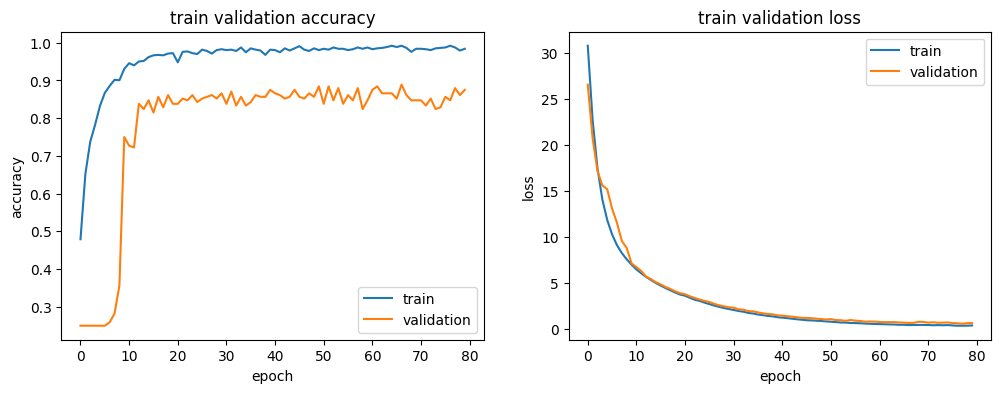

In [27]:
# Train and Validation accuracy and loss
f = plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
plt.title('train validation accuracy')
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(1,2,2)
plt.title('train validation loss')
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')

In [28]:
mfcc_test = mfcc_file['mfcc_test']
y_test_mfcc = mfcc_file['y_test']

In [29]:
# Feature Scaling
mfcc_test_scaled = (mfcc_test - np.mean(mfcc_test))/np.std(mfcc_test)
# Reshape the data
N,row,col = mfcc_test_scaled.shape
mfcc_test_reshaped = mfcc_test_scaled.reshape((N,row,col,1))

In [30]:
y1_prob = model1.predict(mfcc_test_reshaped)
y1_pred = np.argmax(y1_prob, axis = -1)

4/4 [==============================] - 1s 127ms/step


In [31]:
# Accuracy
acc_mfcc = round(accuracy_score(y1_pred,y_test_mfcc),2)

              precision    recall  f1-score   support

       Angry       0.97      0.97      0.97        30
       Happy       0.97      1.00      0.98        30
     Relaxed       0.94      1.00      0.97        30
         Sad       1.00      0.90      0.95        30

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120



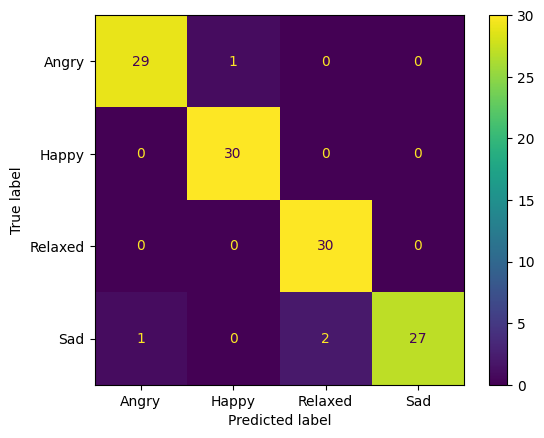

In [32]:
# Confusion Matrix
cm_mfcc = confusion_matrix(y_test_mfcc,y1_pred)
cm_display_mfcc = ConfusionMatrixDisplay(confusion_matrix = cm_mfcc, display_labels = ['Angry', 'Happy', 'Relaxed', 'Sad'])
print(classification_report(y_test_mfcc, y1_pred, target_names = ['Angry', 'Happy', 'Relaxed', 'Sad']))
cm_display_mfcc.plot()
plt.show()

### 4.2 Spectrogram 

In [33]:
# Load Spectrogram data set
spec_file = np.load("Features2D/npz_new/spec_train_test_agumented.npz")

spec_train = spec_file['spec_train']
y2_train = spec_file['y_train']

spec_train,spec_val,y2_train,y2_val = train_test_split(spec_train,y2_train, 
                                                       train_size = 0.8,
                                                       random_state = 13, 
                                                       stratify= y2_train)


In [34]:
# Feature Scaling
spec_train_scaled = spec_train / np.amax(spec_train)
spec_val_scaled = spec_val / np.amax(spec_val)

In [35]:
# Reshape the data
N,row,col = spec_train_scaled.shape
spec_train_reshaped = spec_train_scaled.reshape((N,row,col,1))
N,row,col = spec_val_scaled.shape
spec_val_reshaped = spec_val_scaled.reshape((N,row,col,1))

In [36]:
f1,k1,a1 = 8,3,'relu'
mw1,mh1,sw1,sh1 = 3,3,2,2
f2,k2,a2 = 8,3,'relu'
mw2,mh2,sw2,sh2 = 3,3,2,2
f3,k3,a3 = 16,3,'relu'
mw3,mh3,sw3,sh3 = 3,3,2,2
d1,dr1,da1,r1 = 64,0.2,'relu',0.2
d2,dr2,da2,r2 = 32,0.2,'relu',0.2
num = 2
model2 = modelBuilder3L(spec_train_reshaped,
                        f1,k1,a1,
                        mw1,mh1,sw1,sh1,
                        f2,k2,a2,
                        mw2,mh2,sw2,sh2,
                        f3,k3,a3,
                        mw3,mh3,sw3,sh3,
                        d1,dr1,da1,r1,
                        d2,dr2,da2,r2,
                        num)

Model: "CNN2D_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 200, 200, 8)       80        
                                                                 
 MaxPooling2D_1 (MaxPooling2  (None, 100, 100, 8)      0         
 D)                                                              
                                                                 
 BN1 (BatchNormalization)    (None, 100, 100, 8)       32        
                                                                 
 Conv2D_2 (Conv2D)           (None, 100, 100, 8)       584       
                                                                 
 MaxPooling2D_2 (MaxPooling2  (None, 50, 50, 8)        0         
 D)                                                              
                                                                 
 BN2 (BatchNormalization)    (None, 50, 50, 8)         32  

In [37]:
history2 = model2.fit(spec_train_reshaped,y2_train,validation_data=(spec_val_reshaped,y2_val),batch_size=20,epochs=80)

Epoch 1/80
44/44 [==============================] - 11s 210ms/step - loss: 33.0447 - accuracy: 0.4387 - val_loss: 30.5030 - val_accuracy: 0.3704
Epoch 2/80
44/44 [==============================] - 9s 194ms/step - loss: 27.8546 - accuracy: 0.5741 - val_loss: 26.0688 - val_accuracy: 0.2500
Epoch 3/80
44/44 [==============================] - 8s 191ms/step - loss: 23.4371 - accuracy: 0.6597 - val_loss: 22.9384 - val_accuracy: 0.2500
Epoch 4/80
44/44 [==============================] - 9s 205ms/step - loss: 19.8116 - accuracy: 0.7118 - val_loss: 21.0300 - val_accuracy: 0.2500
Epoch 5/80
44/44 [==============================] - 9s 193ms/step - loss: 16.9327 - accuracy: 0.7384 - val_loss: 19.1434 - val_accuracy: 0.2500
Epoch 6/80
44/44 [==============================] - 9s 197ms/step - loss: 14.6012 - accuracy: 0.7685 - val_loss: 17.5855 - val_accuracy: 0.2500
Epoch 7/80
44/44 [==============================] - 9s 199ms/step - loss: 12.7276 - accuracy: 0.7963 - val_loss: 15.6521 - val_accuracy

In [38]:
# Save model
model2.save(os.getcwd() + "/Features2D/Model/Conv2D_spec_agumented.h5") 

Text(0, 0.5, 'loss')

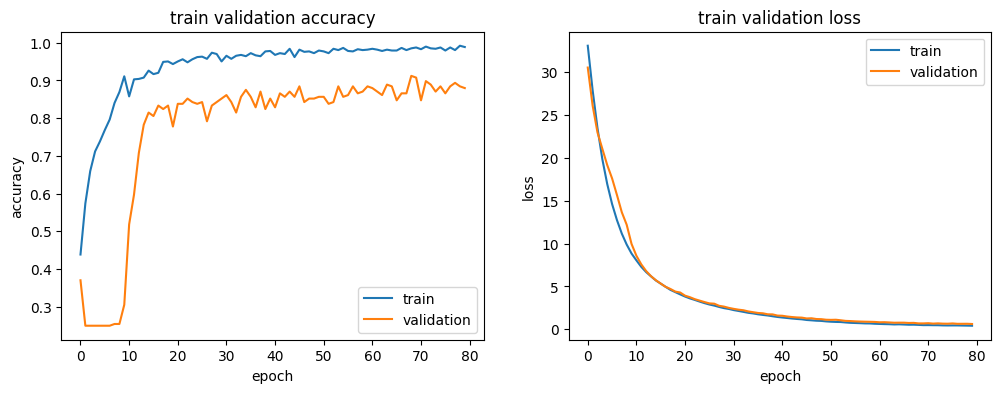

In [39]:
# Train and Validation accuracy and loss
f = plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
plt.title('train validation accuracy')
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(1,2,2)
plt.title('train validation loss')
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')

In [40]:
spec_test = spec_file['spec_test']
y_test_spec = spec_file['y_test']

In [41]:
# Feature Scaling
spec_test_scaled = spec_test / np.amax(spec_test)

# Reshape the data
N,row,col = spec_test_scaled.shape
spec_test_reshaped = spec_test_scaled.reshape((N,row,col,1))

In [42]:
y2_prob = model2.predict(spec_test_reshaped)
y2_pred = np.argmax(y2_prob, axis = -1)

4/4 [==============================] - 0s 71ms/step


In [43]:
# Accuracy
acc_spec = round(accuracy_score(y2_pred,y_test_spec),2)
acc_spec

0.95

              precision    recall  f1-score   support

       Angry       1.00      0.93      0.97        30
       Happy       0.97      1.00      0.98        30
     Relaxed       0.93      0.93      0.93        30
         Sad       0.90      0.93      0.92        30

    accuracy                           0.95       120
   macro avg       0.95      0.95      0.95       120
weighted avg       0.95      0.95      0.95       120



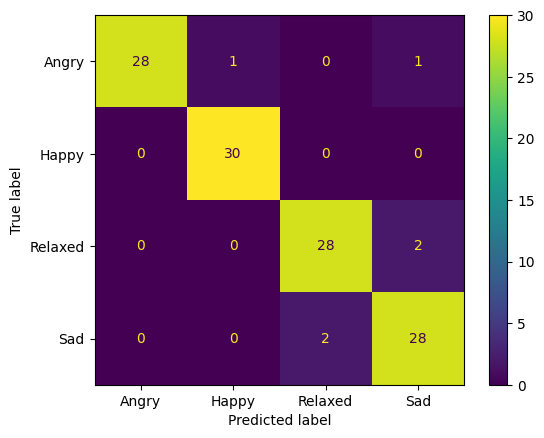

In [44]:
# Confusion Matrix
cm_spec = confusion_matrix(y_test_spec,y2_pred)
cm_display_spec = ConfusionMatrixDisplay(confusion_matrix = cm_spec, display_labels = ['Angry', 'Happy', 'Relaxed', 'Sad'])
print(classification_report(y_test_spec, y2_pred, target_names = ['Angry', 'Happy', 'Relaxed', 'Sad']))
cm_display_spec.plot()
plt.show()

### 4.3 Mel Spectrogram

In [45]:
mel_file = np.load("Features2D/npz_new/mel_train_test_agumented.npz")

mel_train = mel_file['mel_train']
y3_train = mel_file['y_train']
mel_train,mel_val,y3_train,y3_val = train_test_split(mel_train,y3_train, 
                                                     train_size = 0.8, 
                                                     random_state = 13, 
                                                     stratify= y3_train)

In [46]:
# Feature Scaling
mel_train_scaled = (mel_train - np.mean(mel_train))/np.std(mel_train)
mel_val_scaled = (mel_val - np.mean(mel_val))/np.std(mel_val)

In [47]:
# Reshape the data
N,row,col = mel_train_scaled.shape
mel_train_reshaped = mel_train_scaled.reshape((N,row,col,1))

N,row,col = mel_val_scaled.shape
mel_val_reshaped = mel_val_scaled.reshape((N,row,col,1))

In [48]:
f1,k1,a1 = 8,3,'relu'
mw1,mh1,sw1,sh1 = 2,3,2,2
f2,k2,a2 = 8,3,'relu'
mw2,mh2,sw2,sh2 = 2,3,2,2
f3,k3,a3 = 16,3,'relu'
mw3,mh3,sw3,sh3 = 2,3,2,2
d1,dr1,da1,r1 = 64,0.2,'relu',0.2
d2,dr2,da2,r2 = 32,0.2,'relu',0.2
num = 3
model3 = modelBuilder3L(mel_train_reshaped,
                        f1,k1,a1,
                        mw1,mh1,sw1,sh1,
                        f2,k2,a2,
                        mw2,mh2,sw2,sh2,
                        f3,k3,a3,
                        mw3,mh3,sw3,sh3,
                        d1,dr1,da1,r1,
                        d2,dr2,da2,r2,
                        num)

Model: "CNN2D_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 300, 400, 8)       80        
                                                                 
 MaxPooling2D_1 (MaxPooling2  (None, 150, 200, 8)      0         
 D)                                                              
                                                                 
 BN1 (BatchNormalization)    (None, 150, 200, 8)       32        
                                                                 
 Conv2D_2 (Conv2D)           (None, 150, 200, 8)       584       
                                                                 
 MaxPooling2D_2 (MaxPooling2  (None, 75, 100, 8)       0         
 D)                                                              
                                                                 
 BN2 (BatchNormalization)    (None, 75, 100, 8)        32  

In [49]:
history3 = model3.fit(mel_train_reshaped,y3_train,validation_data=(mel_val_reshaped,y3_val),batch_size=20,epochs=80)

Epoch 1/80
44/44 [==============================] - 25s 504ms/step - loss: 31.6717 - accuracy: 0.5069 - val_loss: 27.8993 - val_accuracy: 0.5509
Epoch 2/80
44/44 [==============================] - 21s 478ms/step - loss: 24.2368 - accuracy: 0.6887 - val_loss: 21.4496 - val_accuracy: 0.5648
Epoch 3/80
44/44 [==============================] - 21s 468ms/step - loss: 18.8156 - accuracy: 0.7662 - val_loss: 17.1390 - val_accuracy: 0.5972
Epoch 4/80
44/44 [==============================] - 20s 459ms/step - loss: 15.0470 - accuracy: 0.8310 - val_loss: 14.0896 - val_accuracy: 0.5880
Epoch 5/80
44/44 [==============================] - 20s 460ms/step - loss: 12.4899 - accuracy: 0.8889 - val_loss: 12.1420 - val_accuracy: 0.5556
Epoch 6/80
44/44 [==============================] - 20s 464ms/step - loss: 10.6847 - accuracy: 0.8877 - val_loss: 10.5005 - val_accuracy: 0.6343
Epoch 7/80
44/44 [==============================] - 20s 460ms/step - loss: 9.3443 - accuracy: 0.9062 - val_loss: 8.9322 - val_accu

In [50]:
model3.save(os.getcwd() + "/Features2D/Model/Conv2D_mel_agumented.h5") 

Text(0, 0.5, 'loss')

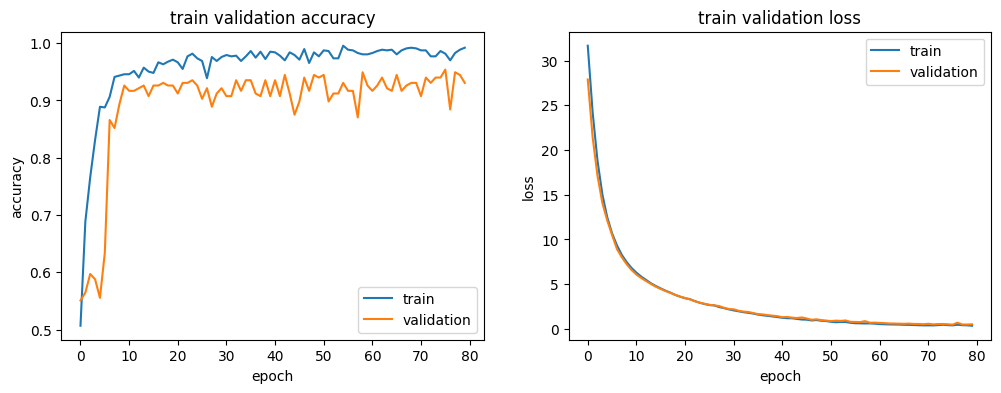

In [51]:
# Train and Validation accuracy and loss
f = plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
plt.title('train validation accuracy')
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(1,2,2)
plt.title('train validation loss')
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')

In [52]:
mel_test = mel_file['mel_test']
y_test_mel = mel_file['y_test']

In [53]:
mel_test_scaled = (mel_test - np.mean(mel_test))/np.std(mel_test)

# Reshape the data
N,row,col = mel_test_scaled.shape
mel_test_reshaped = mel_test_scaled.reshape((N,row,col,1))

In [54]:
y3_prob = model3.predict(mel_test_reshaped)
y3_pred = np.argmax(y3_prob, axis = -1)

4/4 [==============================] - 1s 252ms/step


In [55]:
# Accuracy
acc_mel = round(accuracy_score(y3_pred,y_test_mel),2)
acc_mel

0.96

              precision    recall  f1-score   support

       Angry       1.00      0.90      0.95        30
       Happy       0.94      1.00      0.97        30
     Relaxed       0.94      0.97      0.95        30
         Sad       0.97      0.97      0.97        30

    accuracy                           0.96       120
   macro avg       0.96      0.96      0.96       120
weighted avg       0.96      0.96      0.96       120



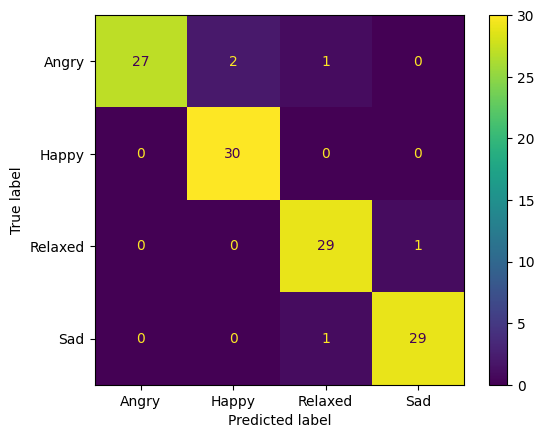

In [56]:
# Confusion Matrix
cm_mel = confusion_matrix(y_test_mel,y3_pred)
cm_display_mel = ConfusionMatrixDisplay(confusion_matrix = cm_mel, display_labels = ['Angry', 'Happy', 'Relaxed', 'Sad'])
print(classification_report(y_test_mel, y3_pred, target_names = ['Angry', 'Happy', 'Relaxed', 'Sad']))
cm_display_mel.plot()
plt.show()

## 5. Ensenble 3 Models

In [57]:
mfcc_file_ense = np.load(os.getcwd() + "/Features2D/npz_new/mfcc_train_test_agumented.npz")
mfcc_ense_train = mfcc_file_ense['mfcc_train']
mfcc_ense_test =mfcc_file_ense['mfcc_test']
y_ense_train = mfcc_file_ense['y_train']
y_ense_test = mfcc_file_ense['y_test']
model_mfcc = load_model(os.getcwd() + "/Features2D/Model/Conv2D_mfcc_agumented.h5")

In [58]:
spec_file_ense = np.load(os.getcwd() + "/Features2D/npz_new/spec_train_test_agumented.npz")
spec_ense_train = spec_file_ense['spec_train']
spec_ense_test = spec_file_ense['spec_test']
y_ense_train = spec_file_ense['y_train']
y_ense_test = spec_file_ense['y_test']
model_spec = load_model(os.getcwd() + "/Features2D/Model/Conv2D_spec_agumented.h5")

In [59]:
mel_file_ense = np.load(os.getcwd() + "/Features2D/npz_new/mel_train_test_agumented.npz")
mel_ense_train = mel_file_ense['mel_train']
mel_ense_test =mel_file_ense['mel_test']
y_ense_train = mel_file_ense['y_train']
y_ense_test = mel_file_ense['y_test']
model_mel = load_model(os.getcwd() + "/Features2D/Model/Conv2D_mel_agumented.h5")

In [60]:
# Feature Scaling
mfcc_ense_train_scaled = (mfcc_ense_train - np.mean(mfcc_ense_train))/np.std(mfcc_ense_train)
spec_ense_train_scaled = spec_ense_train / np.amax(spec_ense_train)
mel_ense_train_scaled = (mel_ense_train - np.mean(mel_ense_train))/np.std(mel_ense_train)

mfcc_ense_test_scaled = (mfcc_ense_test - np.mean(mfcc_ense_test))/np.std(mfcc_ense_test)
spec_ense_test_scaled = spec_ense_test / np.amax(spec_ense_test)
mel_ense_test_scaled = (mel_ense_test - np.mean(mel_ense_test))/np.std(mfcc_ense_test)


# Reshape the data
N,row,col = mfcc_ense_train_scaled.shape
mfcc_ense_train_reshaped = mfcc_ense_train_scaled.reshape((N,row,col,1))
N,row,col = spec_ense_train_scaled.shape
spec_ense_train_reshaped = spec_ense_train_scaled.reshape((N,row,col,1))
N,row,col = mel_ense_train_scaled.shape
mel_ense_train_reshaped = mel_ense_train_scaled.reshape((N,row,col,1))

N,row,col = mfcc_ense_test_scaled.shape
mfcc_ense_test_reshaped = mfcc_ense_test_scaled.reshape((N,row,col,1))
N,row,col = spec_ense_test_scaled.shape
spec_ense_test_reshaped = spec_ense_test_scaled.reshape((N,row,col,1))
N,row,col = mel_ense_test_scaled.shape
mel_ense_test_reshaped = mel_ense_test_scaled.reshape((N,row,col,1))

In [61]:
# Train 3 models
y_ense_prob1 = model_mfcc.predict(mfcc_ense_train_reshaped)
y_ense_pred1 = np.argmax(y_ense_prob1, axis= -1)

y_ense_prob2 = model_spec.predict(spec_ense_train_reshaped)
y_ense_pred2 = np.argmax(y_ense_prob2, axis= -1)

y_ense_prob3 = model_mel.predict(mel_ense_train_reshaped)
y_ense_pred3 = np.argmax(y_ense_prob3, axis= -1)

34/34 [==============================] - 9s 232ms/step


In [62]:
# Vote for most accuracte prediction
def get_majority(pred) :
    N = len(pred[0]) # num of examples
    vote = [] 
    for i in range(N) :
        elements = [j[i] for j in pred] # 3 Prediction results  using 3 different model
        elements = np.array(elements)
        uniq, freq = np.unique(elements, return_counts= True) # Count the occurence of unqiue result
        vote.append(uniq[np.argmax(freq)])# Choose the prediction with most occurence
    
    vote = np.array(vote)
    return vote

In [63]:
# 3 different predictions
train_pred = [y_ense_pred1, y_ense_pred2, y_ense_pred3]

In [64]:
y_train_pred = get_majority(train_pred)

In [65]:
# Model Evaluation
train_corr = len(y_train_pred) - np.count_nonzero(y_train_pred - y_ense_train)
train_acc = np.round((train_corr/ len(y_train_pred)),4)
train_acc

0.9861

In [66]:
# Test ensembled models
y_test_prob1 = model_spec.predict(spec_ense_test_reshaped)
y_test_pred1 = np.argmax(y_test_prob1, axis= -1)

y_test_prob2 = model_mfcc.predict(mfcc_ense_test_reshaped)
y_test_pred2 = np.argmax(y_test_prob2, axis= -1)

y_test_prob3 = model_mel.predict(mel_ense_test_reshaped)
y_test_pred3 = np.argmax(y_test_prob3, axis= -1)

4/4 [==============================] - 1s 198ms/step


In [67]:
test_pred = [y_test_pred1, y_test_pred2, y_test_pred3]

In [68]:
y_test_pred = get_majority(test_pred)

In [69]:
# Model Evaluation
test_corr = len(y_test_pred) - np.count_nonzero(y_test_pred - y_ense_test)
test_acc = np.round((test_corr/ len(y_test_pred)),4)
test_acc

0.9583

              precision    recall  f1-score   support

       Angry       0.97      0.97      0.97        30
       Happy       0.97      1.00      0.98        30
     Relaxed       0.91      1.00      0.95        30
         Sad       1.00      0.87      0.93        30

    accuracy                           0.96       120
   macro avg       0.96      0.96      0.96       120
weighted avg       0.96      0.96      0.96       120



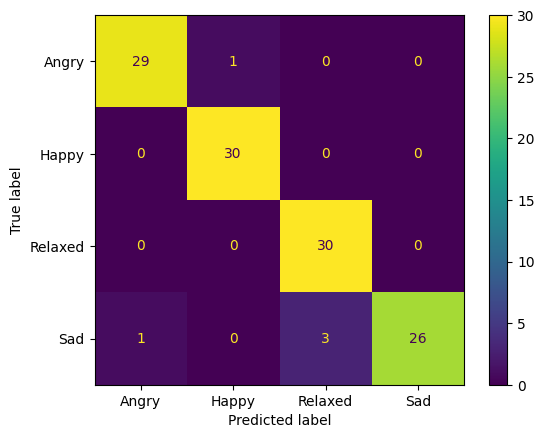

In [70]:
# Confusion Matrix
cm_ense = confusion_matrix(y_ense_test,y_test_pred)
cm_display_ense = ConfusionMatrixDisplay(confusion_matrix = cm_ense, display_labels = ['Angry', 'Happy', 'Relaxed', 'Sad'])
print(classification_report(y_ense_test, y_test_pred, target_names = ['Angry', 'Happy', 'Relaxed', 'Sad']))
cm_display_ense.plot()
plt.show()

In [ ]:
model_mfcc = load_model(os.getcwd() + "/Features2D/Model/Conv2D_mfcc_agumented.h5")
model_spec = load_model(os.getcwd() + "/Features2D/Model/Conv2D_spec_agumented.h5")
model_mel = load_model(os.getcwd() + "/Features2D/Model/Conv2D_mel_agumented.h5")

In [ ]:
f_prob_mfcc = model_mfcc.predict(f_mfcc_reshaped)
f_pred_mfcc = np.argmax(f_prob_mfcc, axis= -1)

f_prob_spec = model_spec.predict(f_spec_reshaped)
f_pred_spec = np.argmax(f_prob_spec, axis= -1)

f_prob_mel = model_mel.predict(f_mel_reshaped)
f_pred_mel = np.argmax(f_prob_mel, axis= -1)

f_pred3 = [f_pred_mfcc,f_pred_spec,f_pred_mel]
f_pred = get_majority(f_pred3)

1/1 [==============================] - 0s 133ms/step
